# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                                                                                                                                                  
Sample_026  Q9P232                                                                                                                                                                                                             15.428
Sample_182  Q8IV08                                                                                                                                                                                                             18.973
Sample_033  A0A075B6R9;A0A0C4DH68                                                                                                                                                                                              20.314
Sample_138  Q12907                                                                       

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                                      
Sample_193  K7EIS2;K7EKV3;K7EM70;K7EQL9;Q9BSG5;Q9BSG5-2;Q9BSG5-3   15.460
Sample_191  J3KQ18;P30046                                          13.177
Sample_101  Q9NS85                                                 16.031
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.075
            A0A075B6Q5                 11.605
            A0A075B6R2                 13.259
            A0A075B6S5                 11.453
            A0A087WSY4                 11.705
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.644
            Q9UI40;Q9UI40-2            12.527
            Q9UIW2                     13.627
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.841
            Q9UP79                     12.548
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.039,15.050,16.842,19.863,16.060,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.871,19.067,...,15.528,15.576,14.374,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.166,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.369,17.705,17.039,16.148,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.147,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.656,15.345,17.084,18.708,14.249,19.433,11.321,11.172
Sample_207,15.739,16.877,15.469,16.898,14.376,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.601,12.340,13.310,12.860,12.600,12.922,12.675,13.337,12.060,12.589
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.352,19.067,16.127,...,12.694,13.157,12.567,13.610,13.193,12.838,12.624,13.550,12.669,12.801
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.836,12.516,11.715,13.837,12.552,13.648,13.232,13.558,11.387,13.301
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.788,13.280,12.955,12.411,12.235,13.334,12.739,12.290,12.611,12.360
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.008,12.473,12.779,12.348,11.786,12.855,13.130,12.344,12.668,12.402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.316,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 333.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.92it/s]

100%|██████████| 3/3 [00:00<00:00,  2.97it/s]

100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.98it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.62it/s]

100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.71it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.03it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.43it/s]

100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.92it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.73it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.30it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.15it/s]

100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.82it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.03it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.18it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.88it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.52it/s]

100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.61it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.49it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.63it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.37it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.00it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.90it/s]

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.65it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.75it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.26it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.19it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.91it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.74it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.57it/s]

100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

100%|██████████| 9/9 [00:02<00:00,  3.88it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.38it/s]

 30%|███       | 3/10 [00:00<00:01,  5.88it/s]

 40%|████      | 4/10 [00:00<00:01,  5.00it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.68it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.42it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.28it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.30it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.74it/s]

100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.50it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.78it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.94it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.73it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.53it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.19it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.74it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.77it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.92it/s]

100%|██████████| 11/11 [00:02<00:00,  3.95it/s]

100%|██████████| 11/11 [00:02<00:00,  4.29it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.69it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.93it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.94it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.62it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.81it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.97it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.04it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.09it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.11it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.17it/s]

100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

100%|██████████| 12/12 [00:02<00:00,  4.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.75it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.69it/s]

 31%|███       | 4/13 [00:00<00:02,  4.25it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.06it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.55it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.73it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.84it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.93it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.92it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.98it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.92it/s]

100%|██████████| 13/13 [00:03<00:00,  4.20it/s]

100%|██████████| 13/13 [00:03<00:00,  4.07it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.94it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.25it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.40it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.23it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.22it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.46it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.54it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.57it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.78it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.92it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.05it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.86it/s]

100%|██████████| 14/14 [00:03<00:00,  3.71it/s]

100%|██████████| 14/14 [00:03<00:00,  4.00it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.79it/s]

 20%|██        | 3/15 [00:00<00:02,  5.77it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.98it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.92it/s]

 40%|████      | 6/15 [00:01<00:02,  3.77it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.51it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.59it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.57it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.65it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.77it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.84it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.88it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.79it/s]

100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.003      0.071 0.029          0.562 0.453       0.075   
2             0.004 0.002      0.043 0.015          0.663 0.148       0.447   
3             0.006 0.003      0.057 0.022          0.806 0.087       0.723   
4             0.006 0.004      0.065 0.032          0.799 0.080       0.776   
5             0.004 0.001      0.048 0.019          0.803 0.089       0.767   
6             0.006 0.003      0.059 0.022          0.805 0.093       0.758   
7             0.007 0.004      0.070 0.030          0.816 0.082       0.830   
8             0.004 0.000      0.038 0.003          0.821 0.083       0.827   
9             0.005 0.002      0.050 0.019          0.819 0.081       0.821   
10            0.004 0.001      0.038 0.013          0.818 0.081       0.816   
11            0.004 0.002      0.043 0.015          0.832 0.078       0.814   
12            0.004 0.001      0.041 0.011          0.837 0.076       0.831   
13            0.004 0.002      0.041 0.013          0.821 0.086       0.832   
14            0.004 0.001      0.042 0.009          0.826 0.087       0.826   
15            0.005 0.002      0.044 0.016          0.826 0.087       0.826   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.127 0.125                  0.531 0.037        0.845   
2          0.111   0.522 0.098                  0.633 0.065        0.697   
3          0.091   0.757 0.064                  0.795 0.052        0.886   
4          0.097   0.782 0.064                  0.814 0.054        0.896   
5          0.095   0.780 0.068                  0.812 0.057        0.898   
6          0.105   0.775 0.074                  0.810 0.060        0.897   
7          0.102   0.819 0.075                  0.846 0.064        0.914   
8          0.104   0.820 0.076                  0.847 0.065        0.912   
9          0.100   0.816 0.071                  0.843 0.061        0.914   
10         0.102   0.813 0.072                  0.841 0.062        0.913   
11         0.090   0.819 0.064                  0.846 0.053        0.920   
12         0.093   0.830 0.065                  0.855 0.055        0.923   
13         0.105   0.823 0.078                  0.849 0.066        0.923   
14         0.104   0.822 0.076                  0.848 0.064        0.923   
15         0.101   0.822 0.077                  0.848 0.065        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.820 0.087        210.000 0.000  
2          0.079                  0.653 0.096        210.000 0.000  
3          0.050                  0.867 0.058        210.000 0.000  
4          0.049                  0.874 0.059        210.000 0.000  
5          0.051                  0.880 0.059        210.000 0.000  
6          0.052                  0.880 0.059        210.000 0.000  
7          0.046                  0.900 0.050        210.000 0.000  
8          0.047                  0.895 0.053        210.000 0.000  
9          0.047                  0.898 0.053        210.000 0.000  
10         0.047                  0.897 0.053        210.000 0.000  
11         0.045                  0.907 0.050        210.000 0.000  
12         0.045                  0.907 0.051        210.000 0.000  
13         0.046                  0.906 0.054        210.000 0.000  
14         0.047                  0.906 0.055        210.000 0.000  
15         0.046                  0.904 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 628.55it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.60it/s]

100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.11it/s]

100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.66it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.77it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.77it/s]

100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

100%|██████████| 5/5 [00:01<00:00,  4.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  9.40it/s]

 50%|█████     | 3/6 [00:00<00:00,  7.20it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.90it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.32it/s]

100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

100%|██████████| 6/6 [00:01<00:00,  5.45it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.71it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.10it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.35it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.48it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.36it/s]

100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

100%|██████████| 7/7 [00:01<00:00,  4.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.91it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.34it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.53it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.20it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.15it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.06it/s]

100%|██████████| 8/8 [00:01<00:00,  4.07it/s]

100%|██████████| 8/8 [00:01<00:00,  4.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 10.58it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.64it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.84it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.14it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.80it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.84it/s]

100%|██████████| 9/9 [00:01<00:00,  5.36it/s]

100%|██████████| 9/9 [00:01<00:00,  5.55it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.91it/s]

 30%|███       | 3/10 [00:00<00:01,  5.65it/s]

 40%|████      | 4/10 [00:00<00:01,  4.98it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.60it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.47it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.36it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.97it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.75it/s]

100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.21it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.34it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.69it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.21it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.66it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.23it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.37it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.54it/s]

100%|██████████| 11/11 [00:02<00:00,  4.57it/s]

100%|██████████| 11/11 [00:02<00:00,  4.94it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.38it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.49it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.97it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.09it/s]

 50%|█████     | 6/12 [00:01<00:01,  5.18it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.83it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.95it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.80it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.74it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.90it/s]

100%|██████████| 12/12 [00:02<00:00,  5.24it/s]

100%|██████████| 12/12 [00:02<00:00,  5.12it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.64it/s]

 31%|███       | 4/13 [00:00<00:01,  8.03it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.56it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.25it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  6.92it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.81it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.93it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  6.53it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  6.34it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.56it/s]

100%|██████████| 13/13 [00:01<00:00,  5.30it/s]

100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.47it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.96it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.23it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.93it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.97it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  7.18it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.35it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.46it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.55it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.63it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.68it/s]

100%|██████████| 14/14 [00:01<00:00,  7.72it/s]

100%|██████████| 14/14 [00:01<00:00,  7.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.61it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.04it/s]

 40%|████      | 6/15 [00:00<00:01,  8.45it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.27it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.16it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.07it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.01it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.95it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.08it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.99it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.94it/s]

100%|██████████| 15/15 [00:01<00:00,  7.91it/s]

100%|██████████| 15/15 [00:01<00:00,  8.28it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.039 0.016          0.120 0.291       0.014   
2             0.005 0.002      0.056 0.021          0.654 0.120       0.384   
3             0.005 0.002      0.047 0.017          0.743 0.083       0.626   
4             0.005 0.002      0.054 0.024          0.799 0.091       0.628   
5             0.005 0.002      0.046 0.015          0.810 0.086       0.650   
6             0.004 0.000      0.036 0.003          0.784 0.090       0.641   
7             0.003 0.001      0.028 0.007          0.834 0.082       0.789   
8             0.004 0.001      0.035 0.003          0.831 0.085       0.790   
9             0.002 0.000      0.024 0.004          0.860 0.086       0.807   
10            0.004 0.000      0.037 0.002          0.862 0.088       0.801   
11            0.004 0.000      0.036 0.004          0.860 0.090       0.800   
12            0.002 0.000      0.022 0.002          0.861 0.084       0.796   
13            0.003 0.001      0.030 0.007          0.865 0.080       0.819   
14            0.002 0.000      0.021 0.000          0.868 0.079       0.817   
15            0.002 0.000      0.021 0.000          0.868 0.079       0.815   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.039   0.024 0.064                  0.503 0.017        0.870   
2          0.121   0.468 0.100                  0.612 0.050        0.701   
3          0.101   0.674 0.074                  0.732 0.054        0.796   
4          0.099   0.699 0.082                  0.755 0.059        0.825   
5          0.109   0.716 0.087                  0.769 0.062        0.821   
6          0.118   0.700 0.094                  0.756 0.068        0.840   
7          0.094   0.807 0.072                  0.836 0.059        0.908   
8          0.111   0.806 0.084                  0.836 0.068        0.909   
9          0.098   0.829 0.075                  0.855 0.061        0.928   
10         0.094   0.827 0.073                  0.853 0.059        0.925   
11         0.093   0.825 0.073                  0.851 0.059        0.923   
12         0.106   0.822 0.074                  0.849 0.059        0.929   
13         0.082   0.838 0.058                  0.862 0.048        0.933   
14         0.084   0.838 0.059                  0.862 0.049        0.933   
15         0.089   0.836 0.063                  0.861 0.051        0.931   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.837 0.087        210.000 0.000  
2          0.090                  0.619 0.102        210.000 0.000  
3          0.063                  0.772 0.079        210.000 0.000  
4          0.062                  0.799 0.079        210.000 0.000  
5          0.064                  0.796 0.083        210.000 0.000  
6          0.060                  0.801 0.084        210.000 0.000  
7          0.050                  0.895 0.056        210.000 0.000  
8          0.050                  0.898 0.057        210.000 0.000  
9          0.040                  0.913 0.050        210.000 0.000  
10         0.043                  0.910 0.053        210.000 0.000  
11         0.043                  0.908 0.052        210.000 0.000  
12         0.040                  0.912 0.047        210.000 0.000  
13         0.040                  0.918 0.044        210.000 0.000  
14         0.039                  0.918 0.044        210.000 0.000  
15         0.040                  0.916 0.045 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1494.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 65.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 45.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 42.07it/s]

100%|██████████| 5/5 [00:00<00:00, 41.85it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 40.61it/s]

100%|██████████| 6/6 [00:00<00:00, 38.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 42.98it/s]

100%|██████████| 7/7 [00:00<00:00, 39.85it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 41.47it/s]

100%|██████████| 8/8 [00:00<00:00, 38.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 40.86it/s]

100%|██████████| 9/9 [00:00<00:00, 37.45it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 41.61it/s]

100%|██████████| 10/10 [00:00<00:00, 36.49it/s]

100%|██████████| 10/10 [00:00<00:00, 37.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 42.46it/s]

 91%|█████████ | 10/11 [00:00<00:00, 36.92it/s]

100%|██████████| 11/11 [00:00<00:00, 37.08it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 42.36it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 36.82it/s]

100%|██████████| 12/12 [00:00<00:00, 36.88it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 40.84it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 36.76it/s]

100%|██████████| 13/13 [00:00<00:00, 35.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 42.37it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 36.71it/s]

100%|██████████| 14/14 [00:00<00:00, 35.58it/s]

100%|██████████| 14/14 [00:00<00:00, 36.35it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.04it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 36.53it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 34.60it/s]

100%|██████████| 15/15 [00:00<00:00, 35.36it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.001          0.000 0.000       0.000   
2             0.002 0.000      0.021 0.000          0.673 0.115       0.508   
3             0.002 0.000      0.021 0.001          0.689 0.107       0.545   
4             0.002 0.000      0.021 0.001          0.695 0.089       0.610   
5             0.002 0.000      0.021 0.000          0.714 0.085       0.642   
6             0.002 0.000      0.021 0.000          0.714 0.102       0.632   
7             0.002 0.000      0.021 0.000          0.702 0.097       0.622   
8             0.002 0.000      0.021 0.000          0.688 0.091       0.593   
9             0.002 0.000      0.021 0.000          0.688 0.088       0.646   
10            0.002 0.000      0.021 0.000          0.716 0.085       0.652   
11            0.002 0.000      0.021 0.000          0.713 0.084       0.655   
12            0.002 0.000      0.021 0.000          0.710 0.084       0.656   
13            0.002 0.000      0.021 0.000          0.685 0.083       0.657   
14            0.002 0.000      0.021 0.000          0.677 0.088       0.651   
15            0.002 0.000      0.021 0.000          0.680 0.081       0.672   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.749   
2          0.095   0.571 0.079                  0.659 0.060        0.737   
3          0.096   0.603 0.086                  0.680 0.062        0.757   
4          0.103   0.645 0.078                  0.707 0.058        0.776   
5          0.102   0.671 0.076                  0.726 0.058        0.809   
6          0.111   0.664 0.084                  0.721 0.065        0.807   
7          0.121   0.653 0.091                  0.713 0.069        0.802   
8          0.110   0.631 0.081                  0.696 0.060        0.801   
9          0.129   0.660 0.092                  0.715 0.069        0.814   
10         0.123   0.677 0.090                  0.731 0.068        0.817   
11         0.122   0.676 0.086                  0.730 0.065        0.815   
12         0.120   0.676 0.085                  0.729 0.065        0.812   
13         0.129   0.664 0.090                  0.718 0.070        0.813   
14         0.121   0.659 0.088                  0.712 0.069        0.807   
15         0.111   0.671 0.080                  0.720 0.064        0.812   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.686 0.084        210.000 0.000  
2          0.072                  0.673 0.090        210.000 0.000  
3          0.067                  0.706 0.083        210.000 0.000  
4          0.068                  0.729 0.079        210.000 0.000  
5          0.061                  0.764 0.080        210.000 0.000  
6          0.062                  0.769 0.075        210.000 0.000  
7          0.062                  0.761 0.075        210.000 0.000  
8          0.064                  0.753 0.083        210.000 0.000  
9          0.063                  0.772 0.082        210.000 0.000  
10         0.059                  0.778 0.076        210.000 0.000  
11         0.058                  0.776 0.076        210.000 0.000  
12         0.059                  0.771 0.076        210.000 0.000  
13         0.060                  0.763 0.075        210.000 0.000  
14         0.065                  0.759 0.079        210.000 0.000  
15         0.063                  0.765 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,2,15
score_time,1,2,1
test_precision,12,14,10
test_recall,13,13,15
test_f1,12,14,10
test_balanced_accuracy,12,14,10
test_roc_auc,14,14,10
test_average_precision,12,13,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.67it/s]

 29%|██▊       | 4/14 [00:00<00:01,  9.77it/s]

 43%|████▎     | 6/14 [00:00<00:00,  8.77it/s]

 50%|█████     | 7/14 [00:00<00:00,  8.48it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.29it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  8.14it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.04it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.96it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.92it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.89it/s]

100%|██████████| 14/14 [00:01<00:00,  7.89it/s]

100%|██████████| 14/14 [00:01<00:00,  8.39it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 40.63it/s]

100%|██████████| 10/10 [00:00<00:00, 35.79it/s]

100%|██████████| 10/10 [00:00<00:00, 36.36it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.66it/s]

 29%|██▊       | 4/14 [00:00<00:00, 11.91it/s]

 43%|████▎     | 6/14 [00:00<00:00, 10.54it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.17it/s]

 71%|███████▏  | 10/14 [00:00<00:00,  9.98it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.87it/s]

100%|██████████| 14/14 [00:01<00:00,  9.66it/s]

100%|██████████| 14/14 [00:01<00:00, 10.20it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


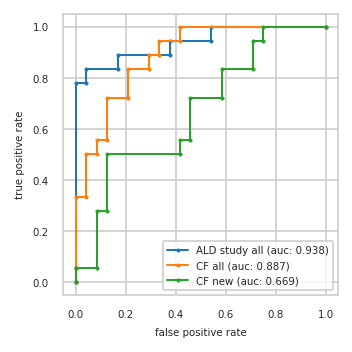

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.778  0.000 0.333  0.083 0.056
3          0.042 0.778  0.042 0.333  0.083 0.278
4          0.042 0.833  0.042 0.500  0.125 0.278
5          0.167 0.833  0.083 0.500  0.125 0.500
6          0.167 0.889  0.083 0.556  0.417 0.500
7          0.375 0.889  0.125 0.556  0.417 0.556
8          0.375 0.944  0.125 0.722  0.458 0.556
9          0.542 0.944  0.208 0.722  0.458 0.722
10         0.542 1.000  0.208 0.833  0.583 0.722
11         1.000 1.000  0.292 0.833  0.583 0.833
12           NaN   NaN  0.292 0.889  0.708 0.833
13           NaN   NaN  0.333 0.889  0.708 0.944
14           NaN   NaN  0.333 0.944  0.750 0.944
15           NaN   NaN  0.417 0.944  0.750 1.000
16           NaN   NaN  0.417 1.000  1.000 1.000
17           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,E5RK69;E7EMC6;P08133;P08133-2,Q9Y490
2,P09486,P02741,P31321
3,K7ERG9;P00746,Q9Y2T3;Q9Y2T3-3,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
4,P14174,P61981,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
5,P10636-2;P10636-6,P04075,Q96GD0
6,P61981,P14174,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,Q6EMK4,Q14894,Q9H741
8,P14618,P63104,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


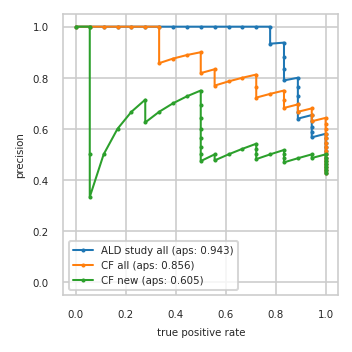

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.621 1.000     0.517 0.833
14         0.607 0.944     0.643 1.000     0.500 0.778
15         0.630 0.944     0.630 0.944     0.481 0.722
16         0.654 0.944     0.654 0.944     0.500 0.722
17         0.640 0.889     0.680 0.944     0.520 0.722
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.696 0.889     0.522 0.667
20         0.727 0.889     0.682 0.833     0.500 0.611
21         0.762 0.889     0.714 0.833     0.476 0.556
22         0.800 0.889     0.750 0.833     0.500 0.556
23         0.789 0.833     0.737 0.778     0.474 0.500
24         0.833 0.833     0.722 0.722     0.500 0.500
25         0.882 0.833     0.765 0.722     0.529 0.500
26         0.938 0.833     0.812 0.722     0.562 0.500
27         0.933 0.778     0.800 0.667     0.600 0.500
28         1.000 0.778     0.786 0.611     0.643 0.500
29         1.000 0.722     0.769 0.556     0.692 0.500
30         1.000 0.667     0.833 0.556     0.750 0.500
31         1.000 0.611     0.818 0.500     0.727 0.444
32         1.000 0.556     0.900 0.500     0.700 0.389
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


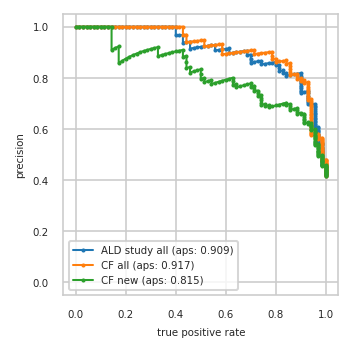

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


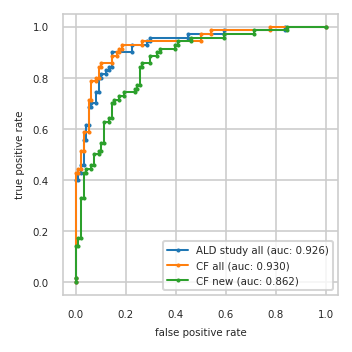

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}